# Analiza trga nepremičnin

V nalogi analiziramo trg nepremičnin na podlagi oglasov zajetih iz največjega slovenskega nepremičninskega portala [nepremicnine.net](nepremicnine.net). Predvsem nas bo zanimalo, kako različni dejavniki (lokacija, starost, ...) vplivajo na ceno nepremičnine.

Odgovorili bomo na sledeča vprašanja in komentirali hipoteze, ki smo si jih zadali pred začetkom dela:
* kako lokacija vpliva na ceno nepremičnine?
* kako velikost vpliva na ceno na kvadratni meter?
* kako starost nepremičnine vpliva na ceno?
* cene nepremičnin na kvadratni meter so v Ljubljani bistveno višje kot drugod,
in še na kakšno več, ki se nam je porodilo med raziskovanjem.

Iz oglasov smo zajeli sledeče podatke:
* id oglasa
* regija
* ime oglasa
* vrsta nepremičnine (stanovanje, hiša, posest, ...)
* tip nepremičnine (podrobnejša razčlenitev vrste - garsonjera, kmetijsko zemljišče, ...)
* velikost zemljišča
* velikost nepremičnine
* cena
* agencija

Najprej smo si uvozili podatke in vsa potrebna orodja za delo.

In [2]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt

%matplotlib inline

nepr_file = os.path.join('podatki/obdelani_podatki', 'nepremicnine_1.csv')
nepr_z_dvojniki = pd.read_csv(nepr_file)

Oglejmo si, kako je v sledeči analizi razdeljena Slovenija, saj je to za razumevanje ključnega pomena. Podatki so razvrščeni po (sedaj zelo aktualnih) statističnih regijah, le Osrednjeslovenska statistična regija je razdeljena na *ljubljana mesto* (označeno z rdečo) in *ljubljana okolica*. Ta delitev je, kot bomo videli, zelo smiselna saj se nepremičninska trga precej razlikujeta.

![Regije](regije.png)

## Pregled podatkov

Preden smo začeli z delom, smo opazili, da se nekateri oglasi ponovijo v več regijah. Vzorca, kako se ponavljajo nismo opazili in smo jih kar izpustili (s tem si nismo pokvarili podatkov, saj je takih oglasov malo).

In [3]:
pd.concat(g for _, g in nepr_z_dvojniki.groupby("id") if len(g) > 1)

,regija,id,ime_oglasa,vrsta_nepremicnine,tip_nepremicnine,zemljisce,velikost,cena,agencija,leto
586,dolenjska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
2547,gorenjska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
4518,koroska,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
5297,ljubljana mesto,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
6178,ljubljana mesto,5787946,"RAKEK, 2 KM OD IZVOZA AC UNEC",Hiša,NaN,270.0,94.0,83000.0,Zasebna ponudba,2010.0
...,...,...,...,...,...,...,...,...,...,...
15360,savinjska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
15673,savinjska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
16118,severna primorska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0
16319,severna primorska,5883962,"LJ. BEŽIGRAD, GLAVARJEVA ULICA",Stanovanje,NaN,NaN,42.0,NaN,D5 invest d.o.o.,1977.0


Spodaj odstranimo dvojnike, dodamo pa stolpce, ki nam bodo v sledeči analizi koristili: *cena_m2*, ki predstavlja ceno na kvadratni meter, *desetletje* za primerjavo starosti nepremičnin in navzdol na 100 m2 zaokroženo velikost.

In [4]:
nepr_brez_dvojnikov = nepr_z_dvojniki.drop_duplicates('id')

nepr = nepr_brez_dvojnikov.set_index('id')

nepr['cena_m2'] = nepr['cena'] / nepr['velikost']

nepr['desetletje'] = (nepr['leto'] // 10) * 10

nepr['zaokrozena_velikost'] = (nepr['velikost'] // 100) * 100

Spodaj so prikazane vse vrste nepremičnin, ki so bile oktobra na voljo. Vidimo, da prevladujejo stanovanja in hiše.

In [5]:
vrste = nepr.groupby('vrsta_nepremicnine')
vrste.size()

vrsta_nepremicnine
Garaža                121
Hiša                 5107
Posest               5071
Poslovni prostor     2095
Počitniški objekt     177
Stanovanje           3361
Vikend                518
dtype: int64

Kot vidimo, je velik del nepremičnin *posesti* - v glavnem gre tu za kmetijska in zazidljiva zemljišča, običajno velike parcele z relativno nizko ceno. Kot take jih je težko primerjati z ostalimi. Njihovi analizi se bomo posvetili kasneje. Pripravimo si tabelo nepremičnin, ki jih ne vključuje.

In [6]:
brez_posesti = nepr[nepr.vrsta_nepremicnine != "Posest"]

## Cena na kvadratni meter po regijah

Prikazan je stolpični diagram povprečnih cen na kvadratni meter po posamezni statistični regiji. Po pričakovanjih, je povprečna cena v Ljubljani precej višja kot drugod. Sledi ji južna Primorska in tako zaželjena stanovanja ob morju, ostale regije pa si sledijo v relativno ozkem intervalu.

Text(0, 0.5, 'Cena na m2')

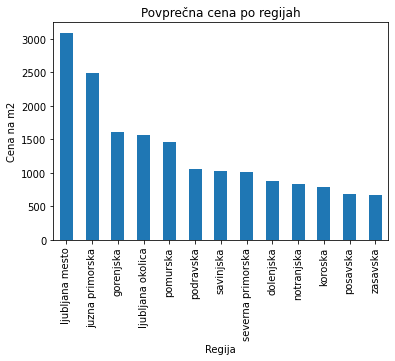

In [7]:
po_regijah = brez_posesti.groupby('regija').mean('cena_m2').sort_values('cena_m2', ascending = False)[['cena_m2']]
gr1 = po_regijah.cena_m2.plot.bar()
gr1.set_title("Povprečna cena po regijah")
gr1.set_xlabel('Regija')
gr1.set_ylabel('Cena na m2')

## Vpliv starosti nepremičnine na ceno


Zanimalo nas bo, kako starost nepremičnine vpliva na njeno ceno - torej kdaj je bila zgrajena. Vidimo, da je nepremičnina v Ljubljani dražja od ostalih, ne glede na njeno starost. Pričakovali smo, da bodo cene stavb iz prve polovice 20. stoletja nižje zaradi slabše potresne gradnje - kot vemo, se je nadzor v Jugoslaviji močno poostril po potresu v Skopju leta 1963 - vendar očitnejšega trenda v tej smeri ni opaziti.

V skoraj vseh regijah pa so cene najnovejših zgradb višje (zopet je ta razlika najočitnejša v Ljubljani).

Na spodnjem grafu je prikazano spreminjanje cene, glede na leto izgradnje po posamezni regiji.

Text(0.5, 1.0, 'Cena po regijah glede na desetletje izgradnje')

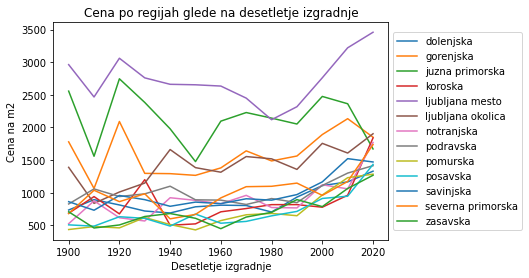

In [8]:
grupiran = brez_posesti[(brez_posesti.desetletje >= 1900) & (brez_posesti.cena_m2 <= 80000)][['regija','cena_m2','desetletje']]

gr2 = grupiran.groupby(['regija','desetletje'])["cena_m2"].mean().unstack(level = 0).plot()
gr2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
gr2.set_ylabel('Cena na m2')
gr2.set_xlabel('Desetletje izgradnje')
gr2.set_title('Cena po regijah glede na desetletje izgradnje')

## Cene po vrsti nepremičnin

Oglejmo si, kako vrsta nepremičnine vpliva na ceno. Tu jemljemo povprečja po vseh regijah in vseh starostih. Vidimo, da je stanovanje povprečno najdražje, presenetljivo pa je nižja povprečna cena hiše. To si lahko razlagamo s tem, da je veliko hiš na prodaj v regijah izven Ljubljane, kjer je cena občutno nižja, stanovanj pa je v Ljubljani na prodaj več. To se precej jasno vidi v spodnjem grafu.

Text(0.5, 1.0, 'Število vrst nepremičnin po regijah')

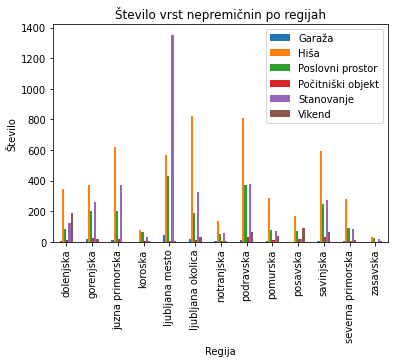

In [27]:
st_po_regijah = brez_posesti.groupby(['regija','vrsta_nepremicnine'])
st_po_regijah_graf = st_po_regijah.size().unstack(level = 1).plot.bar()
st_po_regijah_graf.set_ylabel('Število')
st_po_regijah_graf.set_xlabel('Regija')
st_po_regijah_graf.legend()
st_po_regijah_graf.set_title('Število vrst nepremičnin po regijah')

Text(0.5, 1.0, 'Cena po vrsti nepremičnine')

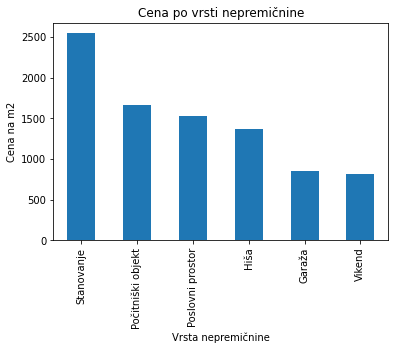

In [10]:
gr3 = brez_posesti.groupby('vrsta_nepremicnine').mean('cena_m2').sort_values('cena_m2',ascending = False).cena_m2.plot.bar()
gr3.set_ylabel('Cena na m2')
gr3.set_xlabel('Vrsta nepremičnine')
gr3.set_title('Cena po vrsti nepremičnine')

Spodaj je vsaka od zgornjih kategorij razdeljena na manjše dele. Zopet preseneča cena najmanjše stanovanjske enote - garsonjere, kar pa lahko razlagamo z njihovo koncentracijo v središču Ljubljane. Visoko na lestvici so tudi pisarne.

Text(0.5, 1.0, 'Cena po tipu nepremičnine')

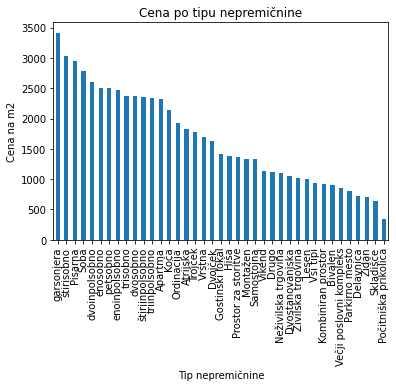

In [11]:
gr4 = brez_posesti.groupby('tip_nepremicnine').mean('cena_m2').sort_values('cena_m2',ascending = False).cena_m2.plot.bar()
gr4.set_ylabel('Cena na m2')
gr4.set_xlabel('Tip nepremičnine')
gr4.set_title('Cena po tipu nepremičnine')

## Vpliv velikosti na ceno

Podrobneje si oglejmo še, kako velikost (zaokrožena na 100 kvadratnih metrov) vpliva na ceno na kvadratni meter. Kot smo videli zgoraj so garsonjere povprečno najdražje, kar se precej jasno odraža tudi na spodnjem grafu. Pri večjih nepremičninah jasnih trendov ni - verjetno tudi zaradi relativno manjšega vzorca.

Text(0.5, 1.0, 'Vpliv velikosti nepremičnine na njeno ceno')

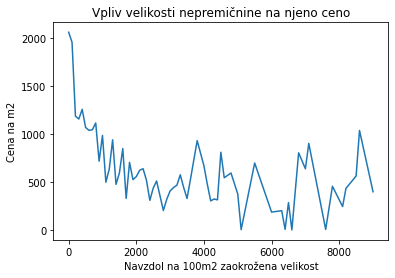

In [12]:
gr5 = brez_posesti[brez_posesti.zaokrozena_velikost < 10000].groupby('zaokrozena_velikost').mean('cena_m2').cena_m2.plot()
gr5.set_ylabel('Cena na m2')
gr5.set_xlabel("Navzdol na 100m2 zaokrožena velikost")
gr5.set_title('Vpliv velikosti nepremičnine na njeno ceno')

# Nezazidane posesti

Za konec preglejmo še prej izpuščene posesti. Najprej opazimo, da so cene pogosto navedene narobe - za primer si oglejmo primer tega zapisa: ![cena](napacna_cena.png)

Cene posesti so, iz meni neznanega razloga, navedene kar direktno v ceni na kvadratni meter (ne tako kot ostale nepremičnine, kjer je bilo to ceno še potrebno izračunati). Pri tem pa se nekajkrat pojavi težava v zapisu decimalnih številk, saj računalnik primer zgoraj prebere kot 208500€ na kvadratni meter, cena celotne posesti pa bi tako bila skoraj 500 000 000€ - očitna napaka. Na srečo pa takih primerov ni prav dosti in se nam vzorec zato ne bo pokvaril.

Zato si bomo cene navzgor omejili s 1000€ na kvadratni meter, saj se s tem izognemo takim izjemam.

In [13]:
posesti = nepr[(nepr.vrsta_nepremicnine == "Posest") & (nepr.cena_m2 < 1000)]
posesti

,regija,ime_oglasa,vrsta_nepremicnine,tip_nepremicnine,zemljisce,velikost,cena,agencija,leto,cena_m2,desetletje,zaokrozena_velikost
id,,,,,,,,,,,,
6167564,dolenjska,BANJA LOKA,Posest,Zazidljiva,NaN,4531.0,99000.0,"PBO nepremičnine, Most inženiring d.o.o.",NaN,21.849481,NaN,4500.0
6319801,dolenjska,BANJA LOKA,Posest,Za investicijo,NaN,5000.0,125000.0,Zasebna ponudba,NaN,25.000000,NaN,5000.0
6104154,dolenjska,BEDENJ,Posest,Kmetija,87300.0,100.0,90000.0,NNRN nepremičnine d.o.o. Novo mesto,1966.0,900.000000,1960.0,100.0
6188600,dolenjska,"BELA CERKEV, ŠMARJEŠKE TOPLICE",Posest,Kmetijsko zemljišče,NaN,3841.0,3800.0,Nepis d.o.o.,NaN,0.989326,NaN,3800.0
6309086,dolenjska,BELI GRIČ,Posest,Zazidljiva,NaN,1301.0,15900.0,NeSta d.o.o.,NaN,12.221368,NaN,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6183700,zasavska,"ZAGORJE OB SAVI, MESTO",Posest,Zazidljiva,NaN,3446.0,99934.0,"MA - nepremičninska družba, Marko Alič s.p.",NaN,29.000000,NaN,3400.0
6329331,zasavska,"ZAGORJE OB SAVI, OKROGARJEVA KOLONIJA",Posest,Zazidljiva,NaN,4173.0,66768.0,NeSta d.o.o.,NaN,16.000000,NaN,4100.0
6315241,zasavska,"ZAGORJE OB SAVI, PODVINE 47",Posest,Zazidljiva,NaN,3954.0,54000.0,Zasebna ponudba,NaN,13.657056,NaN,3900.0


Podobno kot zgoraj, so tudi v tem razdelku cene v regiji *ljubljana mesto* daleč najvišje - tu gre v večini sicer za zazidljive in ne kmetijske parcele. Prikazana je cena na kvadratni meter, pa tudi število posameznih posesti na prodaj po regijah. 

regija
dolenjska             475
gorenjska             376
juzna primorska       661
koroska                70
ljubljana mesto       294
ljubljana okolica    1004
notranjska            132
podravska             923
pomurska              181
posavska              160
savinjska             476
severna primorska     226
zasavska               55
dtype: int64

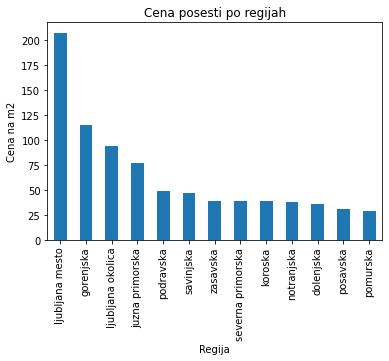

In [14]:
posesti_po_regijah = posesti.groupby('regija')

gr6 = posesti_po_regijah.mean('cena_m2').sort_values('cena_m2', ascending = False).cena_m2.plot.bar()
gr6.set_title('Cena posesti po regijah')
gr6.set_xlabel('Regija')
gr6.set_ylabel('Cena na m2')
posesti_po_regijah.size()

Kot vidimo imajo najvišjo ceno zemljišča *Za investicijo* - prazne parcele, ki pa imajo že urejeno neko osnovno dokumentacijo. Morda presenetljivo, saj je v *Kmetija* vključena tudi hiša. Daleč najnižjo ceno imajo *Kmetijska zemljišča*, torej parcele namenjene kmetovanju brez zgrajene ifrastrukture.

Iz spodnjega grafa se tudi vidi bistveno nižje cene posesti od ostalih nepremičnin.

Text(0, 0.5, 'Cena na m2')

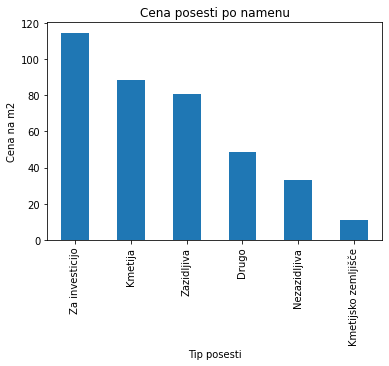

In [15]:
posesti_po_tipu = posesti.groupby('tip_nepremicnine')
gr7 = posesti_po_tipu.mean('cena_m2').sort_values('cena_m2', ascending = False).cena_m2.plot.bar()
gr7.set_title('Cena posesti po namenu')
gr7.set_xlabel('Tip posesti')
gr7.set_ylabel('Cena na m2')


## So cene skozi agencije višje?

Za konec si poglejmo še, če so cene nepremičnin, ki se prodajajo skozi agencije kaj drugačne od zasebnih ponudb.

In [16]:
delo_z_agencijami = brez_posesti[['cena_m2','agencija']]

zasebniki = delo_z_agencijami[delo_z_agencijami.agencija == "Zasebna ponudba"]
agencije = delo_z_agencijami[delo_z_agencijami.agencija != "Zasebna ponudba"]

z = zasebniki[['cena_m2']].mean()
a = agencije[['cena_m2']].mean()
print("Povprečna cena zasebnikov: ",z)
print("Povprečna cena agencij: ", a)

Povprečna cena zasebnikov:  cena_m2    1716.404217
dtype: float64
Povprečna cena agencij:  cena_m2    1723.108856
dtype: float64


Kot vidimo so cene zasebnih ponudb in prodaje skozi agencije zelo podobne.

## Zaključek

Hipoteze smo potrdili - cena nepremičnin v Ljubljani je bistveno višja kot drugod, velja pa to tudi za posesti. Videli smo tudi, da se sestava nepremičninskega trga spreminja med regijami, zopet pa lahko kot izjemo izpostavimo Ljubljano z najvišjim deležem stanovanj, medtem ko so drugod prevladovale hiše. 

Na podlagi starosti težko kaj sklepamo o ceni, le da so novejše nepremičnine v večini dražje. Zanimivo je, da so manjša stanovanja povprečno dražja kot večje hiše, a to razložimo s koncentracijo stanovanj v Ljubljani in posledično višjo ceno.